# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

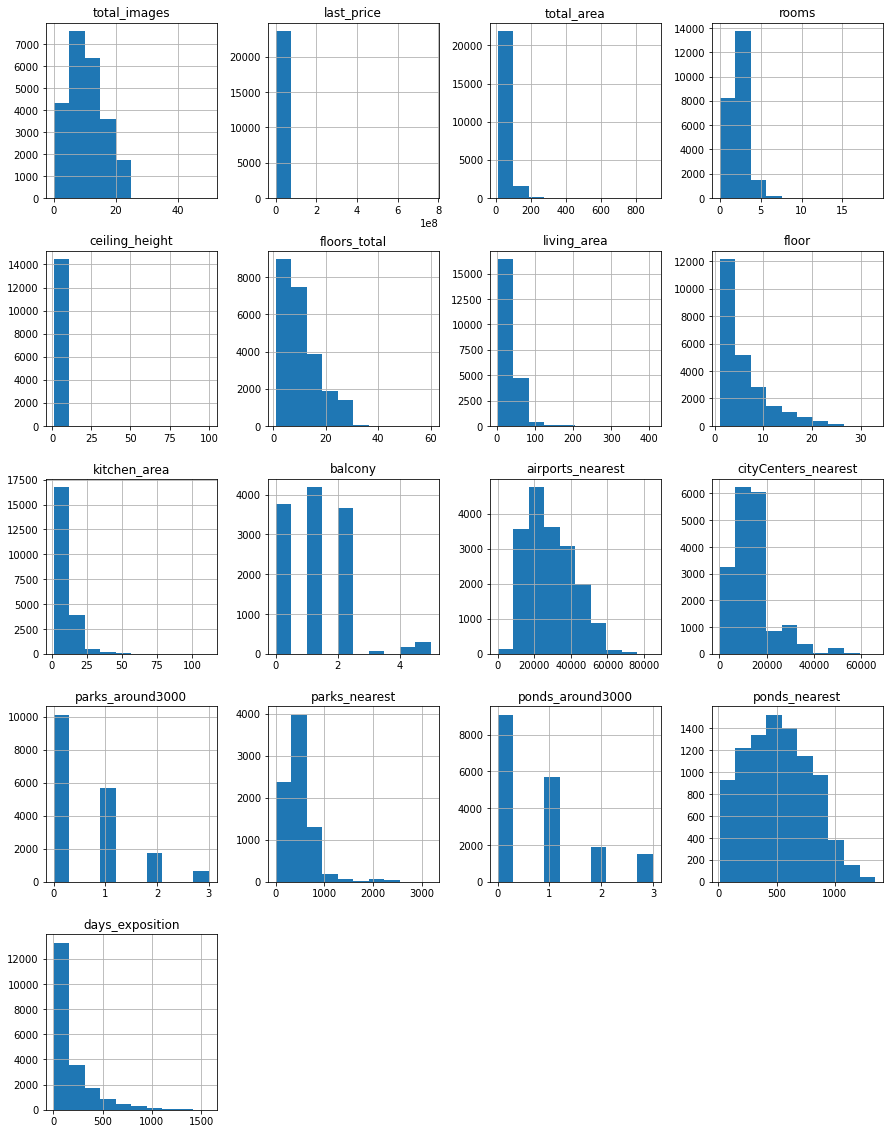

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

#вывожу инфу о данных с колонками и типом данных
data.info()

#строю гистрограммы по всем числовым колонкам
data.hist(figsize=(15, 20))
plt.show()



### Выполните предобработку данных

In [3]:
#найдем, в каких столбцах есть пропуски
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [4]:
#выделим долю пропущенных значений
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


Видно, что критическое кол-во пропусков есть в колонках is_apartment, parks_nearest, ponds_nearest, ceiling_height,balcony. С ними и будем работать.

In [5]:
#заменим пропуски в колонке "balcony" на 0, т.к. скорее всего, балкона нет, если не указали кол-во
data['balcony'] = data['balcony'].fillna(value=0)

#заменим пропуски в 'is_apartment' на "False", т.к. если не указано "да", это не апартаменты
data['is_apartment'] = data['is_apartment'].fillna(value=False)

#удалим строки, в которых floors_total не заполнено, т.к. доля таких пропусков менее 5%, как показано выше
data = data.dropna(subset=['floors_total'])

#заменим пропуски в колонке "days_exposition" на 0, чтобы пропуски не мешали преобразованию типа данных 
data['days_exposition'] = data['days_exposition'].fillna(value=0)

#заменим пропуски в колонке "ceiling_height" на медиану, чтобы пропуски не мешали преобразованию типа данных 
data['ceiling_height'] = data['ceiling_height'].fillna(value=data['ceiling_height'].median())


#проверим, что пропуски ушли в этих колонках
data.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1870
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2231
balcony                     0
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition             0
dtype: int64

**Причины пропусков в данных**

Как известно, данные были заполнены 2мя способами: автоматически и пользователем.
Такие данные как "высота потолка", "количество балконов", "кол-во этажей в доме" заполнялись пользователем и могли быть пропущены по причине невнимательности, незнания этих данных (мало ли)

 - Прочие географические данные получены из геосервисов. Предполагаю, что данные могли быть пропущены из-за технической ошибки или , к примеру, отсутствия данного объекта возле квартиры (если пропущена графа "ближайшие аэропорты" - то их может вовсе и не быть рядом). Такие данные не редактировала, т.к. природа этих пропусков не совсем очевидна.

 - пропуски в "balcony" заменяю на 0, т.к. скорее всего, балконов нет в кв., раз их не заполнили
 
 - нечисловые значения days_exposition заменяю на 0, чтобы в следующем этапе обработки сработало преобразование типа данных

 - пропуски в "is_apartment" заменяю на FALSE, т.к. это булев тип данных, и если там пропуск - значит тип жилья не апартаменты
 - пропусков в 'floors_total' менее 5% - строки с такими пропусками удаляю, сильного искажения это нам не принесет
 - пропуски в 'ceiling_height' заполнила медианой	

In [6]:
# тип данных first_day_exposition должен быть как datetime
data['first_day_exposition'] = data['first_day_exposition'].astype('datetime64')

#тип данных о кол-ве этажей floors_total должен быть целым числом, т.к. этажи не м.б. дробным числом
data['floors_total'] = data['floors_total'].astype('int64')

#тип данных о кол-ве балконов balcony должен быть целым числом, т.к. балконы не м.б. дробным числом
data['balcony'] = data['balcony'].astype('int64')

#тип данных о кол-ве дней объявления days_exposition должен быть целым числом, т.к. дни не м.б. дробным числом
data['days_exposition'] = data['days_exposition'].astype('int64')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

**Причины изменения типов данных**

Тип данных может быть некорректный опять-таки из-за невнимательности, т.е. введен лишний пробел между цифрами в числе, указан какой-нибудь знак или буква, мешающие распознать данные значения как числовой, например.

Если тип данных будет некорректный, как это было сейчас, то в дальнейшем это повлияет на результаты анализа, либо Питон не сможет выполнить заданные ему операции из кода

Поэтому, я изменила тип данных о времени, о кол-ве этажей, о кол-ве балконов и кол-ве дней объявления (в коде это закомментировано дополнительно)

Так же в процессе преобразования обнаружила пропуски в виде nan в колонке 'days_exposition', из-за чего преобразование не получалось, но внесла это в предыдущий шаг, т.к. именно в нем работаю с пропусками.


In [7]:
#выведем уникальные значения с названиями местности, чтобы иметь старый список = переименовываю наш датафрейм далее
data_clear = data
data['locality_name'].unique()


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [8]:
#и выведем кол-во уникальных значений старого датафрейма, чтобы отслеживать, как изменилось кол-во и изменилось ли вообще
len(data['locality_name'].unique())

365

In [9]:
#переименуем неочевидные дубликаты

data_clear['locality_name'] = (
data_clear['locality_name']
.str.replace('поселок','посёлок')
.replace('Мурино','посёлок Мурино')
.replace('посёлок городского типа Рябово','посёлок Рябово')

)

#проверим, есть ли явные дубликаты
print('Количество явных дубликатов:', data_clear.duplicated().sum())


Количество явных дубликатов: 0


In [10]:
#выведем кол-во уникальных значений нового датафрейма
len(data_clear['locality_name'].unique())

329

В наших данных оказалось много похожий названий местности, например, которые отличаются всего на 1 букву е и ё, или кроме самого названия имели еще и слово "поселок" в названии. Вручную привела такие наименования к единому виду. При этом явных дублирующихся строк не обнаружено.
    
Совет: необходимо унифицировать наименование местности.  

### Добавьте в таблицу новые столбцы

In [11]:
#выведу названия колонок для удобства
data_clear.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [12]:
#создам колонку с ценой за метр и округлю до 2 знаков после запятой
data_clear['price_meter'] = (data_clear['last_price'] / data_clear['total_area']).round(2)

#создам колонку днем недели, где 0-понедельник
data_clear['weekday'] = data_clear['first_day_exposition'].dt.weekday

#создам колонку с месяцем публикации объявления
data_clear['month'] = data_clear['first_day_exposition'].dt.month

#создам колонку c годом публикации объявления
data_clear['year'] = data_clear['first_day_exposition'].dt.year

#data_clear['weekday'] = data_clear['first_day_exposition'].dt.date.astype('datetime64[M]')
#data_clear['weekday']



In [13]:
#создам колонку c типом этажа квартиры (значения — «первый», «последний», «другой»)

In [14]:
#пропишу функцию, которая добавит колонку с типом этажа

def type(floor):
    
    if floor['floor'] <= 1:
        return 'первый'
    if floor['floor'] == floor['floors_total']:
        return 'последний'
    else:
        return 'другой'

data_clear['type_floor'] = data_clear.apply(type, axis=1)
data_clear['type_floor'].value_counts()
    

другой       17363
последний     3336
первый        2914
Name: type_floor, dtype: int64

In [15]:
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

In [16]:
#создам колонку с расстоянием до центра города в километрах
data_clear['dist_center_km'] = (data_clear['cityCenters_nearest'] / 1000).round()

#создам колонку с ценой в млн.руб., чтобы далее график строился нагляднее
data_clear['last_price_mil'] = (data_clear['last_price'] / 1000000).round(2)

### Проведите исследовательский анализ данных

**4.1. Анализ параметров**

In [17]:
#выведу новый перечень колонок для удобства анализа
data_clear.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_meter', 'weekday', 'month',
       'year', 'type_floor', 'dist_center_km', 'last_price_mil'],
      dtype='object')

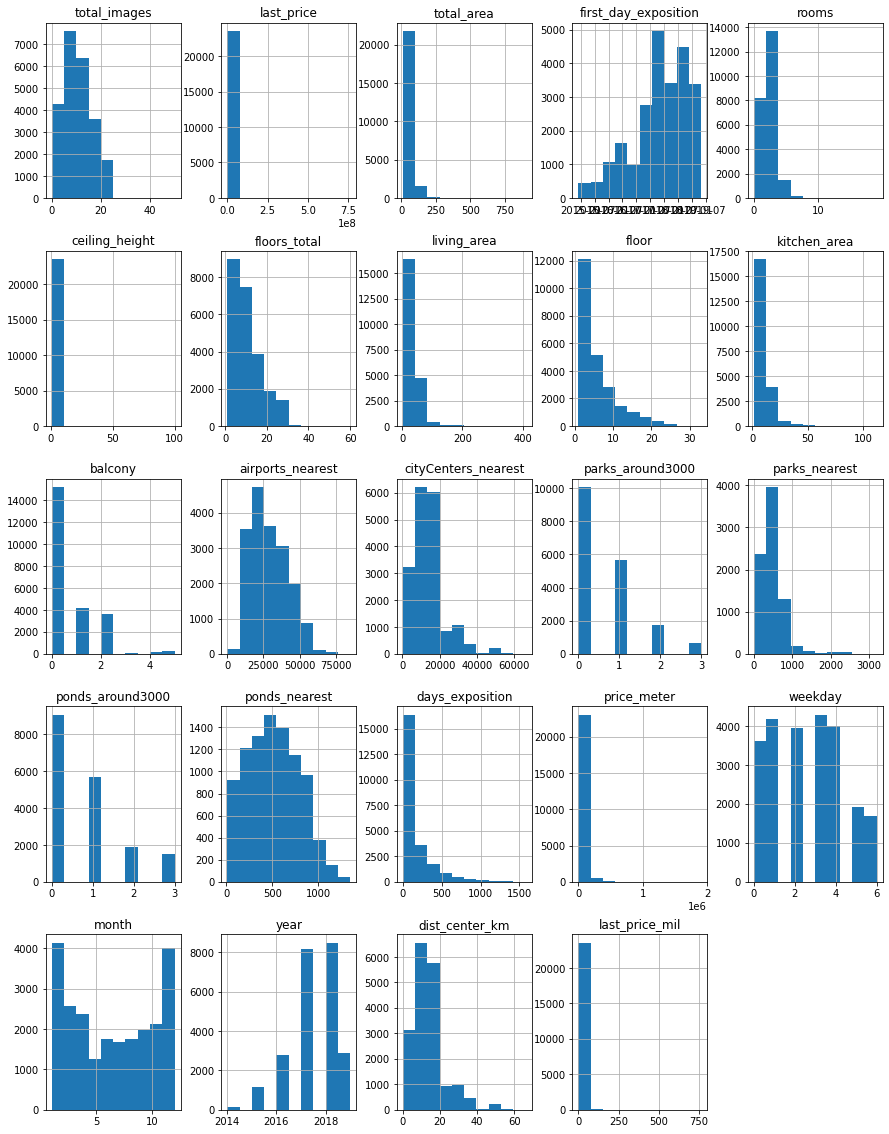

In [18]:
#построим гистограммы как требует задание
data_clear.hist(figsize=(15, 20))
plt.show()

**Анализ общей площади**

In [19]:
#каждый раз буду перезаписывать наш датафрейм, чтобы в итоге осталась единая таблица со всеми очищенными колонками

In [20]:
#узнаю основное описание данных в колонке
new_data = data_clear
new_data['total_area'].describe()

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

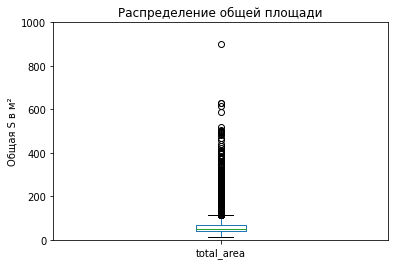

In [21]:
#индивидуальный график
new_data['total_area'].plot.box(title='Распределение общей площади', ylabel='Общая S в м²')
plt.ylim(0, 1000)
plt.show()

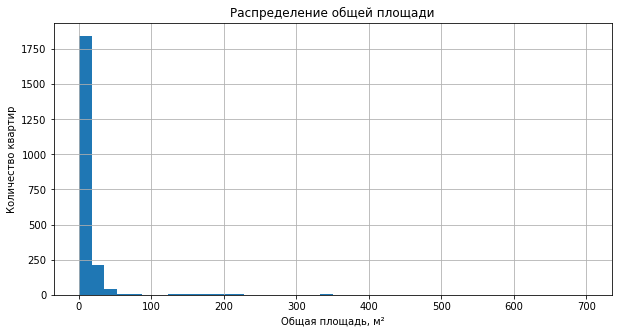

In [22]:
#new_data['total_area'].plot(y='total_area', style ='o', grid=True, figsize=(10,5))
new_data['total_area'].value_counts().hist(grid=True, figsize=(10,5), range=(0,700), bins=40)
plt.title('Распределение общей площади')  
plt.xlabel('Общая площадь, м²')  
plt.ylabel('Количество квартир')
plt.show()

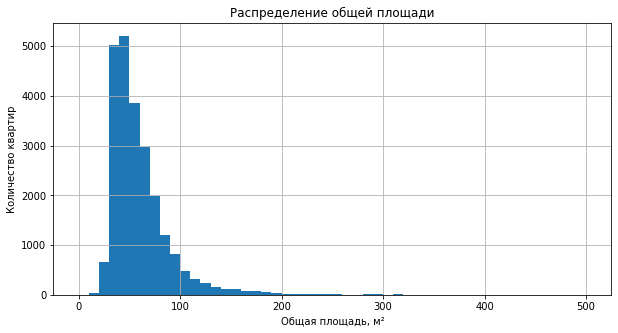

In [24]:
new_data = new_data.query('total_area <= 400')
#new_data.plot(x='total_area', style ='o', grid=True, figsize=(10,5), title='Распределение общей площади', ylabel='Общая S в м²')
new_data['total_area'].hist(grid=True, figsize=(10,5), range=(0,500), bins=50)
plt.title('Распределение общей площади')  
plt.xlabel('Общая площадь, м²')  
plt.ylabel('Количество квартир')
plt.show()

In [25]:
new_data['total_area'].describe()

count    23590.000000
mean        59.903580
std         32.628352
min         12.000000
25%         40.000000
50%         52.000000
75%         69.677500
max        400.000000
Name: total_area, dtype: float64

In [26]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23590 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23590 non-null  int64         
 1   last_price            23590 non-null  float64       
 2   total_area            23590 non-null  float64       
 3   first_day_exposition  23590 non-null  datetime64[ns]
 4   rooms                 23590 non-null  int64         
 5   ceiling_height        23590 non-null  float64       
 6   floors_total          23590 non-null  int64         
 7   living_area           21726 non-null  float64       
 8   floor                 23590 non-null  int64         
 9   is_apartment          23590 non-null  bool          
 10  studio                23590 non-null  bool          
 11  open_plan             23590 non-null  bool          
 12  kitchen_area          21362 non-null  float64       
 13  balcony         

**Вывод по Общей площади**

Диаграмма размаха и описание нам показывает, что есть выбросы после значения 800, так же видно, что после значения 400 данных очень мало, отбросим их. Выведем заново график. Теперь это больше похоже на правду, т.к. в мире существуют и большие квартиры с площадью более чем 50м2 (наше среднее значение). Так же уменьшили среднее отклонение от среднего (std). Теперь наше распределение похоже на "нормальное".

Чаще всего встречаются квартиры с площадью около 50 м2.

**Анализ жилой площади**

In [27]:
new_data['living_area'].describe()

count    21726.000000
mean        34.272174
std         20.849484
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        264.500000
Name: living_area, dtype: float64

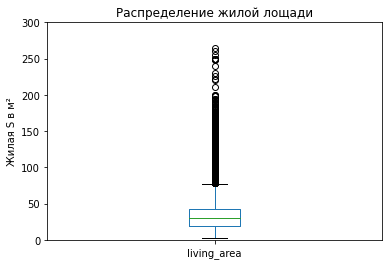

In [28]:
new_data['living_area'].plot.box(title='Распределение жилой лощади', ylabel='Жилая S в м²')
plt.ylim(0, 300)
plt.show()


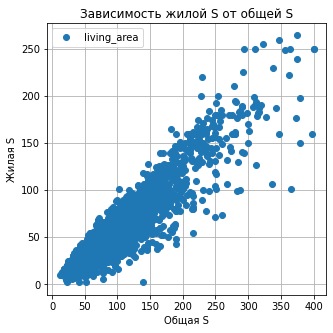

In [29]:
new_data.plot(x='total_area', y='living_area', style ='o', grid=True, figsize=(5,5), 
              title='Зависимость жилой S от общей S', xlabel='Общая S', ylabel='Жилая S')
plt.show()

In [30]:
new_data = new_data.query('5 <= living_area <= 250')
new_data['living_area'].describe()

count    21719.000000
mean        34.246837
std         20.678738
min          5.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        250.000000
Name: living_area, dtype: float64

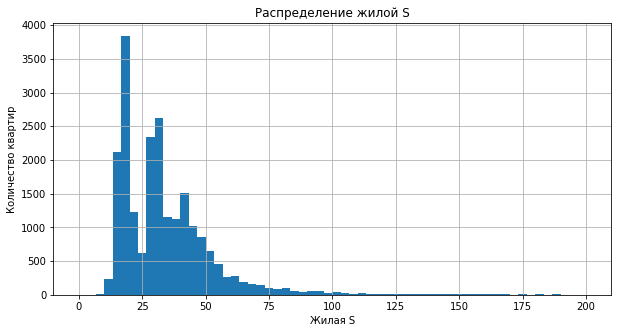

In [31]:
#new_data['living_area'].plot()
new_data['living_area'].hist(grid=True, figsize=(10,5), range=(0,200), bins=60)
plt.title('Распределение жилой S')  
plt.xlabel('Жилая S')  
plt.ylabel('Количество квартир')
plt.show()

**Вывод по Жилой площади**

В целом, прослеживается логичное увеличение жилой площади с увеличением общей площади, однако, уберем значения близкие к 0 (менее 5 м) и выше 250 м, т.к. они слишком нетипичные. 
Наибольшее кол-во объявлений с жилой площадью до 50 м2.

**Анализ кухни**


In [33]:
new_data['kitchen_area'].describe()

count    20920.000000
mean        10.477742
std          5.690992
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

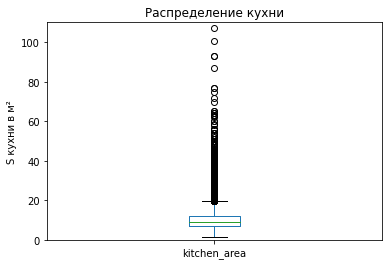

In [34]:
new_data['kitchen_area'].plot.box(title='Распределение кухни', ylabel='S кухни в м²')
plt.ylim(0, 110)
plt.show()

In [35]:
#new_data = new_data.query('kitchen_area <= 100')

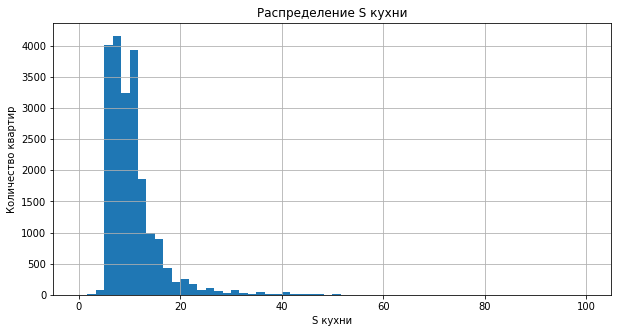

In [36]:
#new_data['kitchen_area'].plot()
new_data['kitchen_area'].hist(grid=True, figsize=(10,5), range=(0,100), bins=60)
plt.title('Распределение S кухни')  
plt.xlabel('S кухни')  
plt.ylabel('Количество квартир')
plt.show()

In [37]:
new_data['kitchen_area'].describe()

count    20920.000000
mean        10.477742
std          5.690992
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

**Вывод по Кухне**

Наиболее популярная площадь кухни в объявлениях - до 20 м.

**Анализ стоимости (в млн ден.ед.)**

In [39]:
new_data['last_price_mil'].describe()

count    21719.000000
mean         6.384074
std          9.575503
min          0.010000
25%          3.450000
50%          4.650000
75%          6.750000
max        763.000000
Name: last_price_mil, dtype: float64

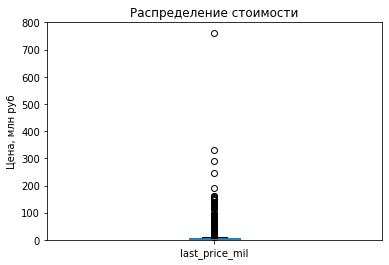

In [40]:
new_data['last_price_mil'].plot.box(title='Распределение стоимости', ylabel='Цена, млн руб')
plt.ylim(0, 800)
plt.show()

In [41]:
new_data = new_data.query('last_price_mil <= 400')

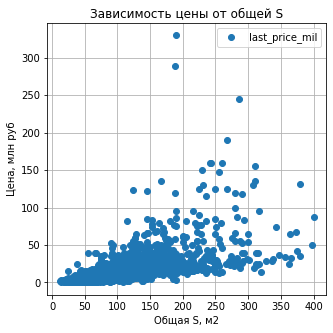

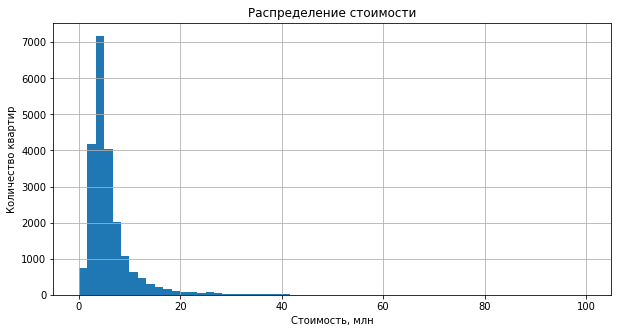

In [42]:
new_data.plot(x='total_area', y='last_price_mil', style ='o', grid=True, figsize=(5,5), 
              ylabel='Цена, млн руб', xlabel='Общая S, м2', title='Зависимость цены от общей S')
plt.show()
new_data['last_price_mil'].hist(grid=True, figsize=(10,5), range=(0,100), bins=60)
plt.title('Распределение стоимости')
plt.xlabel('Стоимость, млн')  
plt.ylabel('Количество квартир')
plt.show()

In [43]:
new_data['last_price_mil'].describe()

count    21718.000000
mean         6.349236
std          8.082878
min          0.010000
25%          3.450000
50%          4.650000
75%          6.750000
max        330.000000
Name: last_price_mil, dtype: float64

**Вывод по стоимости**
Цена в основном лежит в диапазоне от 3 до 7 млн. Так же в целом виден рост цены с ростом общей площади помещения.


**Анализ кол-ва комнат**

In [44]:
new_data['rooms'].describe()

count    21718.000000
mean         2.066949
std          1.062114
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64

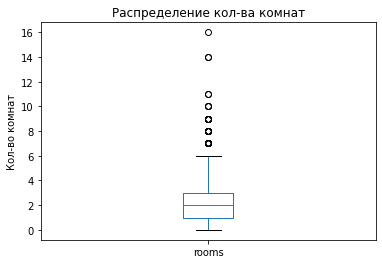

In [45]:
new_data['rooms'].plot.box(title='Распределение кол-ва комнат', ylabel='Кол-во комнат')
plt.show()


In [46]:
new_data = new_data.query('rooms <= 12')

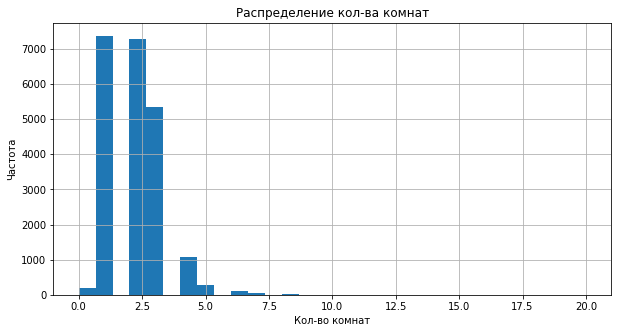

In [47]:
new_data['rooms'].hist(grid=True, figsize=(10,5), range=(0,20), bins=30)
plt.title('Распределение кол-ва комнат')
plt.xlabel('Кол-во комнат')  
plt.ylabel('Частота')
plt.show()

In [48]:
new_data['rooms'].describe()

count    21715.000000
mean         2.065208
std          1.051753
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64

**Вывод по комнатам**

Из общей картины выбивались комнаты более 12-от них избавились.
В основном, наибольшая популярность у 1-2 комнатных квартир.

**Анализ потолков**

In [50]:
new_data['ceiling_height'].describe()

count    21715.000000
mean         2.727028
std          1.030145
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

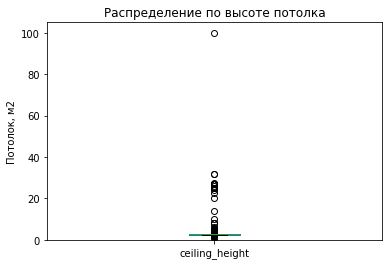

In [51]:
new_data['ceiling_height'].plot.box(title='Распределение по высоте потолка', ylabel='Потолок, м2')
plt.ylim(0, 105)
plt.show()

In [52]:
new_data = new_data.query('ceiling_height <= 40')
new_data['ceiling_height'].max()


32.0

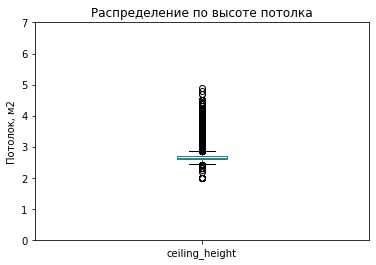

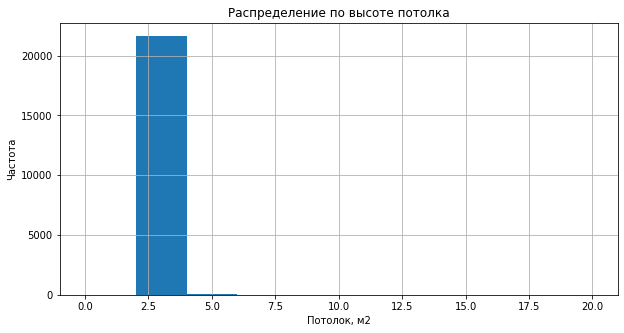

In [53]:
new_data.loc[new_data['ceiling_height'] >= 30, 'ceiling_height'] /= 10
new_data.loc[new_data['ceiling_height'] >5, 'ceiling_height'] = new_data['ceiling_height'].median()
new_data.loc[new_data['ceiling_height'] <2, 'ceiling_height'] = new_data['ceiling_height'].median()

new_data['ceiling_height'].plot.box(title='Распределение по высоте потолка', ylabel='Потолок, м2')
plt.ylim(0, 7)
plt.show()
new_data['ceiling_height'].hist(grid=True, figsize=(10,5), range=(0,20), bins=10)
plt.title('Распределение по высоте потолка')
plt.xlabel('Потолок, м2')  
plt.ylabel('Частота')
plt.show()

In [54]:
new_data['ceiling_height'].unique()

array([2.7 , 2.65, 3.03, 2.5 , 2.67, 2.56, 3.05, 2.75, 2.6 , 2.9 , 2.8 ,
       2.55, 3.  , 3.2 , 2.61, 3.25, 3.45, 2.77, 2.85, 2.64, 2.57, 4.15,
       3.5 , 3.3 , 2.71, 4.  , 2.47, 2.73, 2.84, 3.1 , 3.4 , 2.72, 2.54,
       2.51, 2.78, 2.76, 2.58, 3.7 , 2.52, 2.87, 2.66, 2.59, 2.  , 2.45,
       3.6 , 2.92, 3.11, 3.13, 3.8 , 3.15, 3.55, 3.62, 3.12, 2.53, 2.96,
       2.46, 2.74, 2.95, 4.06, 2.94, 2.79, 3.82, 3.54, 3.53, 2.83, 4.7 ,
       2.4 , 3.38, 3.01, 3.65, 3.9 , 3.18, 3.35, 2.3 , 3.57, 2.48, 2.62,
       2.82, 3.98, 2.63, 3.83, 3.52, 3.95, 3.75, 2.88, 3.67, 3.87, 3.66,
       3.85, 3.86, 4.19, 3.24, 4.8 , 4.5 , 4.2 , 3.36, 3.68, 3.07, 3.37,
       3.09, 3.16, 3.26, 3.34, 2.81, 3.44, 2.97, 3.14, 4.37, 2.68, 3.22,
       3.27, 2.93, 3.46, 3.47, 3.63, 3.33, 3.32, 2.98, 4.1 , 2.86, 3.08,
       3.17, 4.4 , 3.28, 3.04, 4.45, 3.84, 3.23, 3.02, 3.21, 3.43, 3.78,
       4.3 , 3.06, 3.39, 3.31, 3.56, 2.2 , 3.51, 3.93, 3.42, 3.49, 2.91,
       3.88, 4.25, 3.29, 2.25, 3.76, 2.89, 3.58, 2.

**Вывод по потолкам**

В типичной квартире потолок окол 2м. Бывают исключения в виде 3-5 м в исторических постройках. Поэтому, все, что выше 30м делим на 10 (чтобы получилось 3м, 3.5 м и тд), далее все, что больше 5 и меньше 2 - заменяем медианными значениями. В итоге, высота потолка колеблется до 3 м, что уже больше похоже на правду.

**Анализ этажности**

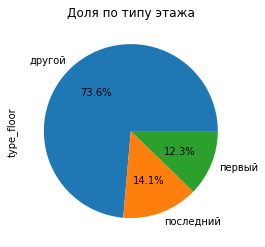

In [56]:
new_data['type_floor'].value_counts().plot(kind='pie',figsize=(4,4), autopct='%1.1f%%', title='Доля по типу этажа')
plt.show()

**Вывод по этажности**

Круговая диаграмма наиболее наглядна будет для нечислового типа данных. В основном, больше объявлений с этажем, отличающимся от первого и последнего. Первый и последний визуально имеют одинаковую долю.


**Анализ кол-ва этажей**

In [57]:
new_data['floors_total'].describe()

count    21714.000000
mean        10.649627
std          6.569898
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

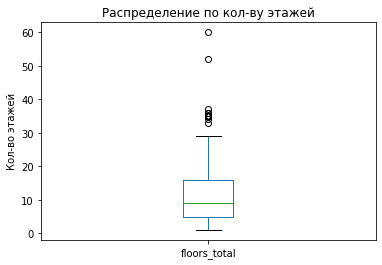

In [58]:
new_data['floors_total'].plot.box(title='Распределение по кол-ву этажей', ylabel='Кол-во этажей')
plt.show()

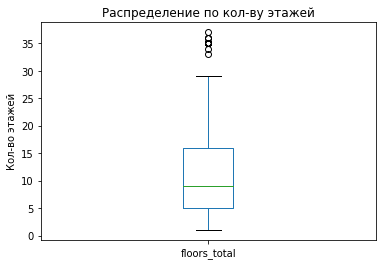

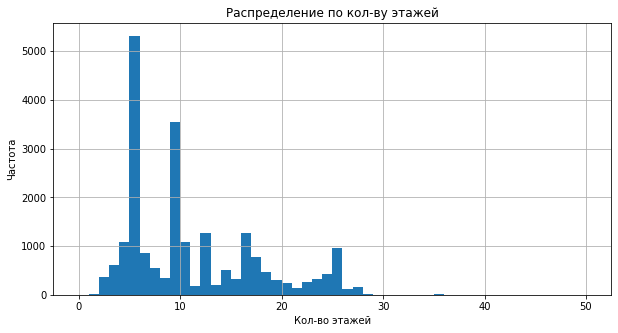

In [59]:
new_data = new_data.query('floors_total <= 50')
#new_data['floors_total'] = new_data['floors_total'].fillna(value=0).astype('int64')
new_data['floors_total'].plot.box(title='Распределение по кол-ву этажей', ylabel='Кол-во этажей')
plt.show()
new_data['floors_total'].hist(grid=True, figsize=(10,5), range=(0,50), bins=50)
plt.title('Распределение по кол-ву этажей')
plt.xlabel('Кол-во этажей')  
plt.ylabel('Частота')
plt.show()

**Вывод по этажам**

Убрали совсем выбивающиеся из общей массы значения более, чем 50 этажей
В основном, объявления в домах с от 5 до 14 этажей.

In [60]:
# Код ревьюера
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21712 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21712 non-null  int64         
 1   last_price            21712 non-null  float64       
 2   total_area            21712 non-null  float64       
 3   first_day_exposition  21712 non-null  datetime64[ns]
 4   rooms                 21712 non-null  int64         
 5   ceiling_height        21712 non-null  float64       
 6   floors_total          21712 non-null  int64         
 7   living_area           21712 non-null  float64       
 8   floor                 21712 non-null  int64         
 9   is_apartment          21712 non-null  bool          
 10  studio                21712 non-null  bool          
 11  open_plan             21712 non-null  bool          
 12  kitchen_area          20914 non-null  float64       
 13  balcony         

**Анализ близости к центру**

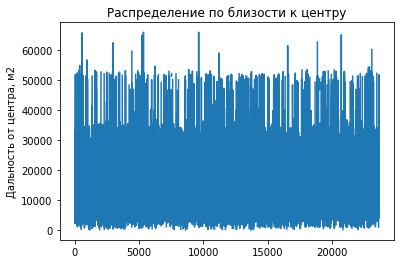

In [61]:
new_data['cityCenters_nearest'].plot(title='Распределение по близости к центру', ylabel='Дальность от центра, м2')
plt.show()

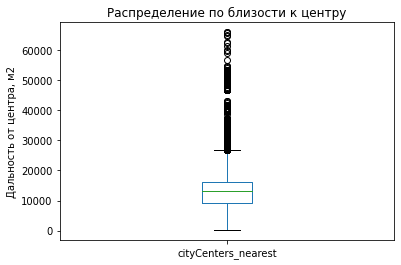

In [62]:
#new_data = new_data.query('cityCenters_nearest <=60000')
new_data['cityCenters_nearest'].plot.box(title='Распределение по близости к центру', ylabel='Дальность от центра, м2')
plt.show()

In [63]:
new_data['cityCenters_nearest'].describe()

count    16822.000000
mean     14241.207288
std       8664.564074
min        181.000000
25%       9320.250000
50%      13111.500000
75%      16268.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

**Вывод по близости к центру**

Основной массив квартир из объявлений находится в удаленности от центра примерно до 40 000 м, а в среднем около 15 000 м.

In [64]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21712 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21712 non-null  int64         
 1   last_price            21712 non-null  float64       
 2   total_area            21712 non-null  float64       
 3   first_day_exposition  21712 non-null  datetime64[ns]
 4   rooms                 21712 non-null  int64         
 5   ceiling_height        21712 non-null  float64       
 6   floors_total          21712 non-null  int64         
 7   living_area           21712 non-null  float64       
 8   floor                 21712 non-null  int64         
 9   is_apartment          21712 non-null  bool          
 10  studio                21712 non-null  bool          
 11  open_plan             21712 non-null  bool          
 12  kitchen_area          20914 non-null  float64       
 13  balcony         

**Анализ близости к паркам**

In [65]:
new_data['parks_nearest'].describe()

count    7461.000000
mean      488.131350
std       338.208439
min         1.000000
25%       287.000000
50%       452.000000
75%       610.000000
max      3190.000000
Name: parks_nearest, dtype: float64

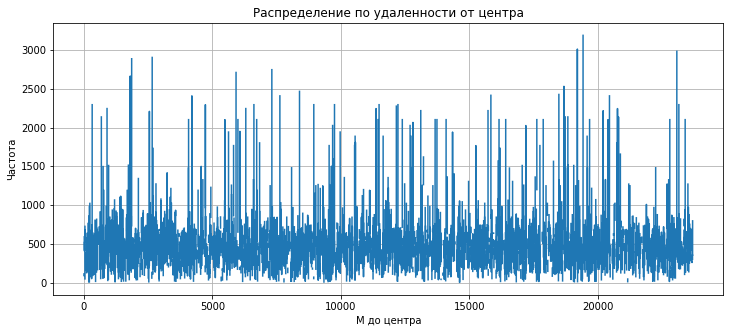

In [66]:
new_data['parks_nearest'].plot(grid=True, figsize=(12,5))
plt.title('Распределение по удаленности от центра')
plt.xlabel('М до центра')  
plt.ylabel('Частота')
plt.show()

In [67]:
#new_data = new_data.query('parks_nearest < 3000')


**Вывод по близости к паркам**

В основном, квартиры в удаленности до 1000 м от парков

**4.2. Скорость продажи квартир**

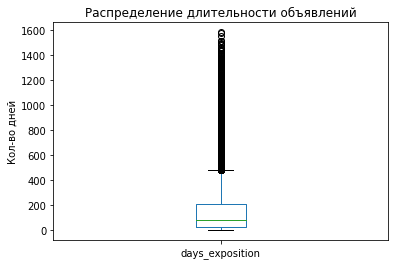

In [69]:
new_data['days_exposition'].plot.box(title='Распределение длительности объявлений', ylabel='Кол-во дней')
plt.show()

In [70]:
new_data = new_data.query('days_exposition >0')
new_data['days_exposition'].describe()

count    18737.000000
mean       184.797940
std        221.136083
min          1.000000
25%         44.000000
50%        101.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Вывод по скорости продаж**

Гистограмма и описание показывают, что ,в основном, в среднем объявления висят в диапазоне до 190 дней. Необычно долгой продажей является продажа после 1400 дня - таких продаже не так много, а слишком быстрой можно считать продажу около 44 дней, т.к. таких продаже менее 25%. (наш показатель Q1)

**4.3.Выявление связи между ценой и прочими параметрами**

**4.3.1. Зависимость цены от общей площади**

In [71]:
#выведу колонки для удобства
new_data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_meter', 'weekday', 'month',
       'year', 'type_floor', 'dist_center_km', 'last_price_mil'],
      dtype='object')

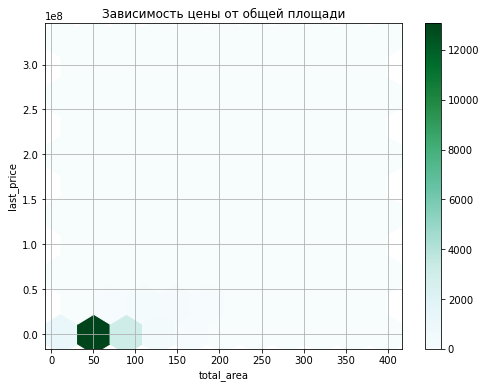

In [72]:
new_data.plot(x='total_area', y='last_price', kind='hexbin', gridsize=10, figsize=(8, 6), sharex=False, grid=True, 
              title='Зависимость цены от общей площади') 
plt.show()

In [73]:
new_data['total_area'].corr(new_data['last_price'])

0.6794364250370628

**Вывод**

График не очень информативный, но к-т корреляции показывает, что зависимость между ценой и общей площадью достаточно высокая - чем больше площадь, тем больше цена

**4.3.2. Зависимость цены от площади кухни**

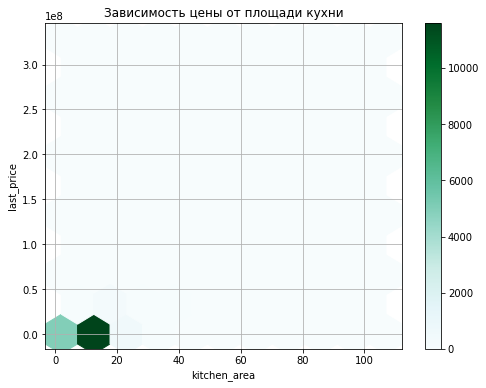

In [74]:
new_data.plot(x='kitchen_area', y='last_price', kind='hexbin', gridsize=10, figsize=(8, 6), sharex=False, grid=True,
             title='Зависимость цены от площади кухни') 
plt.show()

In [75]:
new_data['kitchen_area'].corr(new_data['last_price'])

0.5170632166002543

**Вывод**

График не очень информативный, но к-т корреляции показывает, что зависимость между ценой и общей площадью средняя - чем больше площадь кухни, тем больше цена, но эта логика не всегда актуальна.

**4.3.3. Зависимость цены от жилой площади**

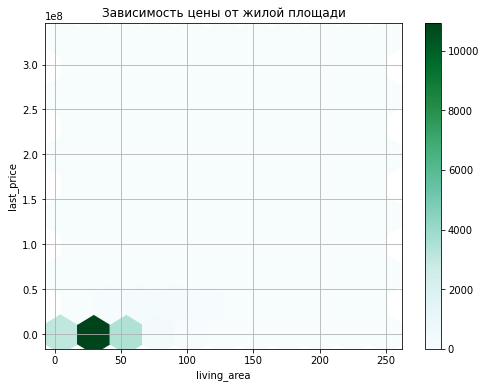

In [76]:
new_data.plot(x='living_area', y='last_price', kind='hexbin', gridsize=10, figsize=(8, 6), sharex=False, grid=True, 
              title='Зависимость цены от жилой площади')
plt.show()

In [77]:
new_data['living_area'].corr(new_data['last_price'])

0.6019205431823628

**Вывод**

График не очень информативный, но к-т корреляции показывает, что зависимость между ценой и общей площадью выше средней - в целом, чем больше жилая площадь, тем больше цена.

**4.3.4. Зависимость цены от кол-ва комнат**

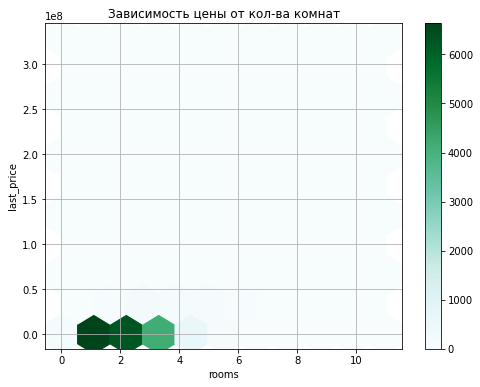

In [78]:
new_data.plot(x='rooms', y='last_price', kind='hexbin', gridsize=10, figsize=(8, 6), sharex=False, grid=True,
             title='Зависимость цены от кол-ва комнат')
plt.show()

In [79]:
new_data['rooms'].corr(new_data['last_price'])

0.40418175947479257

**Вывод**

График не очень информативный, но к-т корреляции показывает, что зависимость между ценой очень слабая. Скорее, цена не зависит от количества комнат в квартире.

**4.3.5. Зависимость цены от этажа**

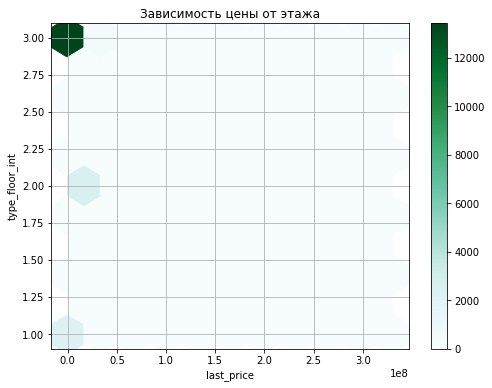

In [80]:
#т.к. корреляция с числовыми значениями работает, дам обозначения типам этажей в новой колонке
def num_floor(floor):
    if floor == 'первый':
        return 1
    if floor == 'последний':
        return 2
    else:
        return 3
    
new_data['type_floor_int'] = new_data['type_floor'].apply(num_floor)
new_data['type_floor_int'].unique()
new_data.plot(x='last_price', y='type_floor_int', kind='hexbin', gridsize=10, figsize=(8, 6), sharex=False, 
              grid=True, title='Зависимость цены от этажа')
plt.show()

In [81]:
#new_data['type_floor_int'].corr(new_data['last_price'])

**Вывод**

Зависимость между ценой и типом этажа нелинейная (т.е. нужно учитывать и другие вводные)

**4.3.5. Зависимость цены от времени размещения объявления**

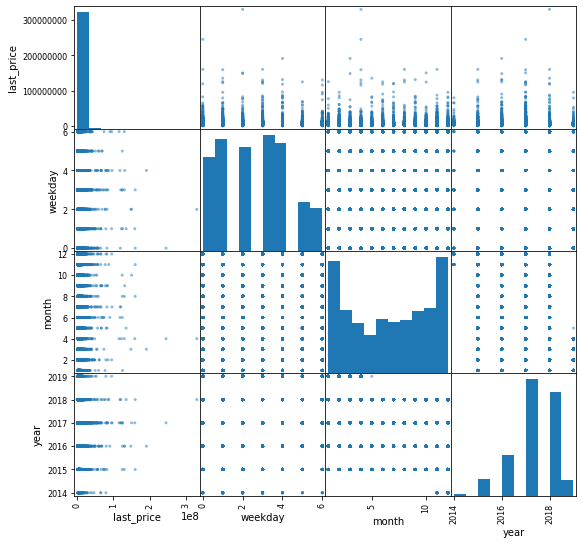

In [82]:
time = new_data[['last_price','weekday', 'month', 'year']]
pd.plotting.scatter_matrix(time, figsize=(9, 9)) 
plt.show()

In [83]:
#(
#new_data['weekday'].corr(new_data['last_price']),
    
#new_data['month'].corr(new_data['last_price']),

#new_data['year'].corr(new_data['last_price'])
    
#)


**Вывод**

Зависимость между ценой и типом этажа нелинейная (т.е. нужно учитывать и другие вводные)

**Анализ населенных пунктов**

In [84]:
locality = new_data.pivot_table(index='locality_name', values='price_meter', aggfunc=('count', 'mean'))
locality.columns = ['кол-во объявлений', 'средняя цена за метр']
loc_max = locality.sort_values(by='кол-во объявлений', ascending=False)
loc_max = loc_max.head(10)
loc_max

,кол-во объявлений,средняя цена за метр
locality_name,,
Санкт-Петербург,12561,111470.827934
посёлок Мурино,486,86353.602922
посёлок Шушары,375,78262.709680
Всеволожск,314,68842.292261
Колпино,298,74758.013758
Пушкин,286,102530.039720
посёлок Парголово,277,89816.024043
деревня Кудрово,262,92702.184313
Гатчина,253,67742.746324


Самая высокая цена в Питере - достигает в среднем 111 тр за метр, а самая низкая в Петергофе - 83 тр за метр

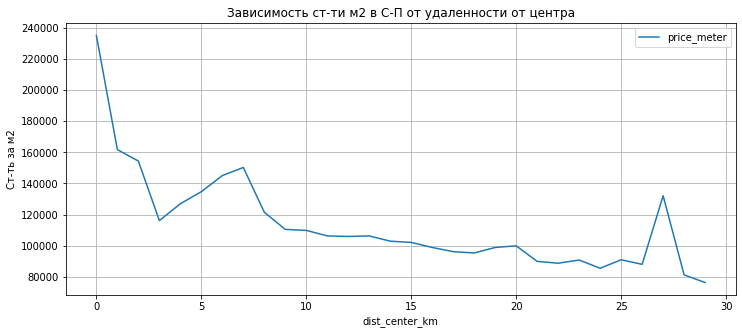

In [85]:
(new_data
.query('locality_name == "Санкт-Петербург"')
.pivot_table(index='dist_center_km', values = 'price_meter')
.plot(grid=True, figsize=(12, 5), title='Зависимость ст-ти м2 в С-П от удаленности от центра', ylabel='Ст-ть за м2')
)

plt.show()

На графике четко прослеживется уменьшение цены с увеличением расстояния до центра города, при этом есть небольшой пик цены около 30 м, вероятно, там влияют и другие вводные.

### Напишите общий вывод

**1)** ***Саммэри по данным***:

- обнаружены пропуски в разных колонках: заменила на 0 если понимала, что это применимо (пр., балконы), заполнила True/False в столбце по типу жилья (квартира ли).
- исправила тип данных на целые числовые значения (кол-во дней, балконов), которые не могут быть дробными.
- удалила неявные дубликаты вручную, которые могли отличаться всего на одну букву е/ё. 

Как известно, данные были заполнены 2мя способами: автоматически и пользователем. Такие данные как "высота потолка", "количество балконов", "кол-во этажей в доме" заполнялись пользователем и могли быть пропущены по причине невнимательности, незнания этих данных (мало ли). Прочие географические данные получены из геосервисов. Предполагаю, что данные могли быть пропущены из-за технической ошибки или , к примеру, отсутствия данного объекта возле квартиры (если пропущена графа "ближайшие аэропорты" - то их может вовсе и не быть рядом). Так же будет правильно унифицировать прописание населенных пунктов. 
Стоит внимательнее обращать внимание на качество заполненной информации в объявлении, т.к. это может повлиять на аналитику

**2)** ***Исследование аномальных значений***:

При помощи гистограмм разной формы были обнаружены аномальные значения, которые встречались очень редко, их удаляли (например, более 100 кв м -  здесь явно какая-то ошибка). Вывод после каждого параметра рассмотрен выше.

**3)** ***От чего зависит стоимость?***:

Между ценой и общей площадью достаточно высокая зависимость- чем больше площадь, тем больше цена. Далее так же зависимость видна и от жилой площади. Обнаружена нелинейная зависимость между ценой и типом этажа и временем публикации объявления (день, месяц, год).

**4)** ***Какой самый дорогой населенный пункт?***:

Самая высокая средняя цена за месяц в Питере - достигает в среднем 111 тр за метр, а самая низкая в Петергофе - 83 тр за метр
Так же в Питере четко прослеживется уменьшение цены с увеличением расстояния до центра города.

